# Pre-signing sentiment vs salary "overpay" (association-only)

This notebook asks a single, paper-friendly question:

> **Does pre-signing sentiment (Reddit fans vs. media) explain salary beyond performance?**

To keep one clear story (and avoid many parallel variants), we use:

- **Outcome (main):** `overpay_resid` = residual from the baseline salary-performance model `log(AAV) ~ WS`.
- **Sentiment (main):** player-level **mean VADER** sentiment.
- **Primary test:** compare baseline vs. extended model fit: `log(AAV) ~ WS` vs. `log(AAV) ~ WS + sentiment` (report **Delta R^2 / Delta adj R^2**).
- **One robustness check (data quality):** for **media**, recompute sentiment using only explicitly attributed sentences (exclude `pronoun_backfill`).
- **One robustness note (model choice):** repeat the main test with **DeBERTa**.

All results are **associational** (no causal claim).


In [123]:
import json
import re
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

SEED = 42
rng = np.random.default_rng(SEED)

pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (10, 5), "axes.grid": True, "grid.alpha": 0.25})


## Load data

Inputs:
- Sentiment JSONL:
  - `data/sentiment_data/media_sentence_sentiment.jsonl`
  - `data/sentiment_data/reddit_sentence_sentiment.jsonl`
- Player cohort list (Fox): `data/player_data/fox_free_agency_signings_2025.csv`
- Contract AAV (Spotrac): `data/player_data/spotrac_signed_free_agents_2025.csv`
- Performance (WS, VORP): `data/player_data/players_advanced_stats.csv`


In [124]:
MEDIA_SENTIMENT_PATH = Path("data/sentiment_data/media_sentence_sentiment.jsonl")
REDDIT_SENTIMENT_PATH = Path("data/sentiment_data/reddit_sentence_sentiment.jsonl")

# Sentence-level filter: keep sentences mentioning <= N other tracked players (besides the target).
MAX_OTHER_PLAYERS_TOLERATED = 1  # set to None to disable filtering

# keep only top N players by sentiment volume 
TOP_N_PLAYERS = 70  
TOP_N_PLAYERS_BY = "combined"  # "reddit", "media", or "combined"

FOX_PLAYERS_PATH = Path("data/player_data/fox_free_agency_signings_2025.csv")
SPOTRAC_CONTRACTS_PATH = Path("data/player_data/spotrac_signed_free_agents_2025.csv")
ADV_STATS_PATH = Path("data/player_data/players_advanced_stats.csv")

OUTPUT_DIR = Path("data/sentiment_data/analysis_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_MODELS = OUTPUT_DIR / "simple_linear_models.csv"


In [125]:
SUFFIXES = {"jr", "sr", "ii", "iii", "iv", "v"}


def normalize_name(name: str) -> str:
    s = str(name or "").strip()
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    parts = s.split()
    if parts and parts[-1] in SUFFIXES:
        parts = parts[:-1]
    return " ".join(parts)


def parse_money(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).replace("$", "").replace(",", "").strip()
    s = re.sub(r"[^0-9.\-]", "", s)
    return float(s) if s else np.nan


def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            if not isinstance(obj, dict) or obj.get("_type") == "url_done":
                continue
            rows.append(obj)
    return pd.DataFrame(rows)


def filter_sentences_by_other_players(df: pd.DataFrame, max_other_players: int | None) -> pd.DataFrame:
    if max_other_players is None or "n_other_players" not in df.columns:
        return df
    d = df.copy()
    d["n_other_players"] = pd.to_numeric(d["n_other_players"], errors="coerce").fillna(0)
    return d[d["n_other_players"] <= max_other_players].reset_index(drop=True)


def restrict_players_by_sentiment_volume(df: pd.DataFrame, top_n: int | None, by: str) -> pd.DataFrame:
    if top_n is None:
        return df

    top_n = int(top_n)
    if top_n <= 0:
        raise ValueError("top_n must be a positive int or None")

    by = str(by or "").strip().lower()
    if "reddit_n_sentences" in df.columns:
        reddit_counts = pd.to_numeric(df["reddit_n_sentences"], errors="coerce").fillna(0)
    else:
        reddit_counts = pd.Series(0.0, index=df.index)
    if "media_n_sentences" in df.columns:
        media_counts = pd.to_numeric(df["media_n_sentences"], errors="coerce").fillna(0)
    else:
        media_counts = pd.Series(0.0, index=df.index)

    if by == "reddit":
        counts = reddit_counts
    elif by == "media":
        counts = media_counts
    elif by == "combined":
        counts = reddit_counts + media_counts
    else:
        raise ValueError('by must be one of: "reddit", "media", "combined"')

    d = df.copy()
    d["_sentiment_volume"] = counts
    sort_cols = ["_sentiment_volume"] + (["player"] if "player" in d.columns else [])
    asc = [False] + ([True] if "player" in d.columns else [])
    d = d.sort_values(sort_cols, ascending=asc).head(top_n)
    d = d.drop(columns=["_sentiment_volume"]).reset_index(drop=True)
    return d


In [126]:
# Sentiment (sentence-level)
media_sent_raw = read_jsonl(MEDIA_SENTIMENT_PATH)
reddit_sent_raw = read_jsonl(REDDIT_SENTIMENT_PATH)

media_sent = filter_sentences_by_other_players(media_sent_raw, MAX_OTHER_PLAYERS_TOLERATED)
reddit_sent = filter_sentences_by_other_players(reddit_sent_raw, MAX_OTHER_PLAYERS_TOLERATED)

print(
    f"media_sent rows: {len(media_sent)} (raw {len(media_sent_raw)}) | players: {media_sent.get('player', pd.Series(dtype=str)).nunique()} | max_other_players={MAX_OTHER_PLAYERS_TOLERATED}"
)
print(
    f"reddit_sent rows: {len(reddit_sent)} (raw {len(reddit_sent_raw)}) | players: {reddit_sent.get('player', pd.Series(dtype=str)).nunique()} | max_other_players={MAX_OTHER_PLAYERS_TOLERATED}"
)


media_sent rows: 25779 (raw 26011) | players: 66 | max_other_players=1
reddit_sent rows: 8062 (raw 8095) | players: 50 | max_other_players=1


After filtering, we retain 25,779 media and 8,062 Reddit sentences covering 66 and 50 players respectively. This confirms the media-heavy imbalance and motivates analyzing sources separately.

## Aggregate sentiment to player level (separately for media and reddit)

Features:
- `mean_*` for VADER + DeBERTa
- `mean_*_r_pos` and `mean_*_r_neg` where `r_pos = log(pos/neu)` and `r_neg = log(neg/neu)`
- `n_sentences`
- `mean_n_other_players` (how often the sentence mentions other tracked players)


In [127]:
SENT_EPS = 1e-9


def aggregate_sentiment(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    d = df.copy()
    d["player"] = d["player"].astype(str)
    d["player_key"] = d["player"].apply(normalize_name)

    num_cols = [
        "vader",
        "deberta",
        "n_other_players",
        "vader_pos",
        "vader_neu",
        "vader_neg",
        "deberta_pos",
        "deberta_neu",
        "deberta_neg",
    ]
    for c in num_cols:
        if c not in d.columns:
            d[c] = np.nan
        d[c] = pd.to_numeric(d[c], errors="coerce")

    g = d.groupby("player_key").agg(
        n_sentences=("sentence", "count"),
        mean_vader=("vader", "mean"),
        mean_deberta=("deberta", "mean"),
        mean_vader_pos=("vader_pos", "mean"),
        mean_vader_neu=("vader_neu", "mean"),
        mean_vader_neg=("vader_neg", "mean"),
        mean_deberta_pos=("deberta_pos", "mean"),
        mean_deberta_neu=("deberta_neu", "mean"),
        mean_deberta_neg=("deberta_neg", "mean"),
        mean_n_other_players=("n_other_players", "mean"),
    )

    g = g.reset_index()
    g["mean_vader_r_pos"] = np.log((g["mean_vader_pos"] + SENT_EPS) / (g["mean_vader_neu"] + SENT_EPS))
    g["mean_vader_r_neg"] = np.log((g["mean_vader_neg"] + SENT_EPS) / (g["mean_vader_neu"] + SENT_EPS))
    g["mean_deberta_r_pos"] = np.log((g["mean_deberta_pos"] + SENT_EPS) / (g["mean_deberta_neu"] + SENT_EPS))
    g["mean_deberta_r_neg"] = np.log((g["mean_deberta_neg"] + SENT_EPS) / (g["mean_deberta_neu"] + SENT_EPS))
    
   
    g = g.drop(
        columns=[
            "mean_vader_pos",
            "mean_vader_neu",
            "mean_vader_neg",
            "mean_deberta_pos",
            "mean_deberta_neu",
            "mean_deberta_neg",
        ]
    )

    g = g.rename(
        columns={
            "player_key": "player_key_norm",
            "n_sentences": f"{prefix}n_sentences",
            "mean_vader": f"{prefix}mean_vader",
            "mean_deberta": f"{prefix}mean_deberta",
            "mean_vader_r_pos": f"{prefix}mean_vader_r_pos",
            "mean_vader_r_neg": f"{prefix}mean_vader_r_neg",
            "mean_deberta_r_pos": f"{prefix}mean_deberta_r_pos",
            "mean_deberta_r_neg": f"{prefix}mean_deberta_r_neg",
            "mean_n_other_players": f"{prefix}mean_n_other_players",
        }
    )
    return g


media_player = aggregate_sentiment(media_sent, "media_")
reddit_player = aggregate_sentiment(reddit_sent, "reddit_")



## Contracts + performance (AAV, WS)

Cohort restriction: players in `fox_free_agency_signings_2025.csv`.

Contract metric: `aav` (average annual value) from Spotrac (fallback: Fox 2025-26 salary when Spotrac is missing).

Performance metrics: `WS`


In [128]:
MIN_SALARY = 1_157_153  # fallback if Fox 2025-26 salary is 0

fox = pd.read_csv(FOX_PLAYERS_PATH)
fox["player"] = fox["player"].astype(str)
fox["player_key_norm"] = fox["player"].apply(normalize_name)
fox["next_year_salary"] = fox["2025-26"].apply(parse_money)
fox["next_year_salary"] = fox["next_year_salary"].replace({0: MIN_SALARY})
cohort = fox[["player", "player_key_norm", "next_year_salary"]].drop_duplicates("player_key_norm")

spot = pd.read_csv(SPOTRAC_CONTRACTS_PATH)
spot_player_col = next(c for c in spot.columns if c.startswith("Player"))
spot_aav_col = next(c for c in spot.columns if "AAV" in c)
spot_years_col = "Yrs"

spot = spot.rename(columns={spot_player_col: "player", spot_aav_col: "aav", spot_years_col: "years"})
spot["player"] = spot["player"].astype(str)
spot["player_key_norm"] = spot["player"].apply(normalize_name)
spot["aav"] = spot["aav"].apply(parse_money)
spot["years"] = pd.to_numeric(spot["years"], errors="coerce")


adv = pd.read_csv(ADV_STATS_PATH)
adv["player"] = adv["Player"].astype(str)
adv["player_key_norm"] = adv["player"].apply(normalize_name)
adv["WS"] = pd.to_numeric(adv["WS"], errors="coerce")
adv["MP"] = pd.to_numeric(adv["MP"], errors="coerce")
adv["Team"] = adv["Team"].astype(str)
adv["is_agg_team"] = adv["Team"].str.match(r"^(TOT|\d+TM)$", na=False)

# Prefer multi-team aggregate row (TOT/2TM/3TM/...) then max minutes.
adv_one = (
    adv.sort_values(["player_key_norm", "is_agg_team", "MP"], ascending=[True, False, False])
    .drop_duplicates("player_key_norm", keep="first")
    [["player_key_norm", "WS"]]
)

df = cohort.merge(spot[["player_key_norm", "aav", "years"]], on="player_key_norm", how="left")
df["aav_source"] = np.where(df["aav"].notna(), "spotrac", np.where(df["next_year_salary"].notna(), "fox_2025-26", ""))
df["aav"] = df["aav"].where(df["aav"].notna(), df["next_year_salary"])
df = df.merge(adv_one, on="player_key_norm", how="left")

df = df.merge(media_player, on="player_key_norm", how="left")
df = df.merge(reddit_player, on="player_key_norm", how="left")

if TOP_N_PLAYERS is not None:
    before = len(df)
    df = restrict_players_by_sentiment_volume(df, TOP_N_PLAYERS, TOP_N_PLAYERS_BY)
    print(f"Restricted cohort to top {len(df)}/{before} players by {TOP_N_PLAYERS_BY} sentiment volume")

df["aav_mil"] = df["aav"] / 1_000_000.0

print("cohort players:", len(df))
print("with AAV (Spotrac):", int((df["aav_source"] == "spotrac").sum()))
print("with AAV (Fox fallback):", int((df["aav_source"] == "fox_2025-26").sum()))
print("with AAV (any):", df["aav"].notna().sum())
print("with WS:", df["WS"].notna().sum())


Restricted cohort to top 66/66 players by combined sentiment volume
cohort players: 66
with AAV (Spotrac): 48
with AAV (Fox fallback): 18
with AAV (any): 66
with WS: 65


Our cohort contains 66 players with AAV available (48 from Spotrac, 18 from Fox 2025–26 fallback). We keep this for coverage, but later treat salary-source mixing as a potential measurement limitation

## Outcomes (salary vs performance)

We keep things simple and run two **association-only** approaches:

1) **AAV model**: `log(aav_mil) ~ WS + sentiment` 
2) **Ratio model**: `aav_mil/performance ~ sentiment`

For ratios we only compute them when the performance stat is **> 0** to avoid divide-by-zero / sign issues.


In [129]:
df = df.copy()

# Main outcome setup
# - log_aav_mil: log(AAV in millions)
# - overpay_resid: residual from baseline log(AAV) ~ WS

df["log_aav_mil"] = np.where(df["aav_mil"] > 0, np.log(df["aav_mil"]), np.nan)

baseline_overpay = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_aav_mil", "WS"]).copy()
if len(baseline_overpay) < 3:
    raise ValueError("Not enough rows with AAV and WS to fit baseline overpay model")

baseline_ws_fit = smf.ols("log_aav_mil ~ WS", data=baseline_overpay).fit()

df["overpay_resid"] = df["log_aav_mil"] - baseline_ws_fit.predict(df)

print(f"Baseline (full cohort): log(AAV) ~ WS | n={int(baseline_ws_fit.nobs)} | R2={baseline_ws_fit.rsquared:.3f}")


Baseline (full cohort): log(AAV) ~ WS | n=65 | R2=0.368


## Main analysis: incremental explanatory power of sentiment

We run the main analysis **separately** for Reddit and media using **mean VADER sentiment**:

- Baseline: `log(AAV) ~ WS`
- Extended: `log(AAV) ~ WS + sentiment_mean`

We report **Delta R^2** and **Delta adj R^2** (how much fit improves when adding sentiment).

Then we visualize the overpay residual (`overpay_resid`) vs. sentiment with a fitted line + 95% CI.


,source,sentiment_model,nobs,baseline_r2,extended_r2,delta_r2,baseline_adj_r2,extended_adj_r2,delta_adj_r2,coef_sentiment,p_sentiment,cv_n_test,cv_rmse_baseline,cv_rmse_extended,cv_delta_rmse,cv_r2_baseline,cv_r2_extended,cv_delta_r2
0,media,vader,65,0.368363,0.368892,0.000529,0.358337,0.348533,-0.009804,-0.394708,0.820469,13,0.411153,0.410436,-0.000718,0.598903,0.600302,0.001399
1,reddit,vader,49,0.340898,0.365691,0.024793,0.326875,0.338112,0.011238,0.686050,0.186543,10,0.548510,0.501739,-0.046771,0.242216,0.365937,0.123721


Wrote: data\sentiment_data\analysis_outputs\main_overpay_models_vader.csv


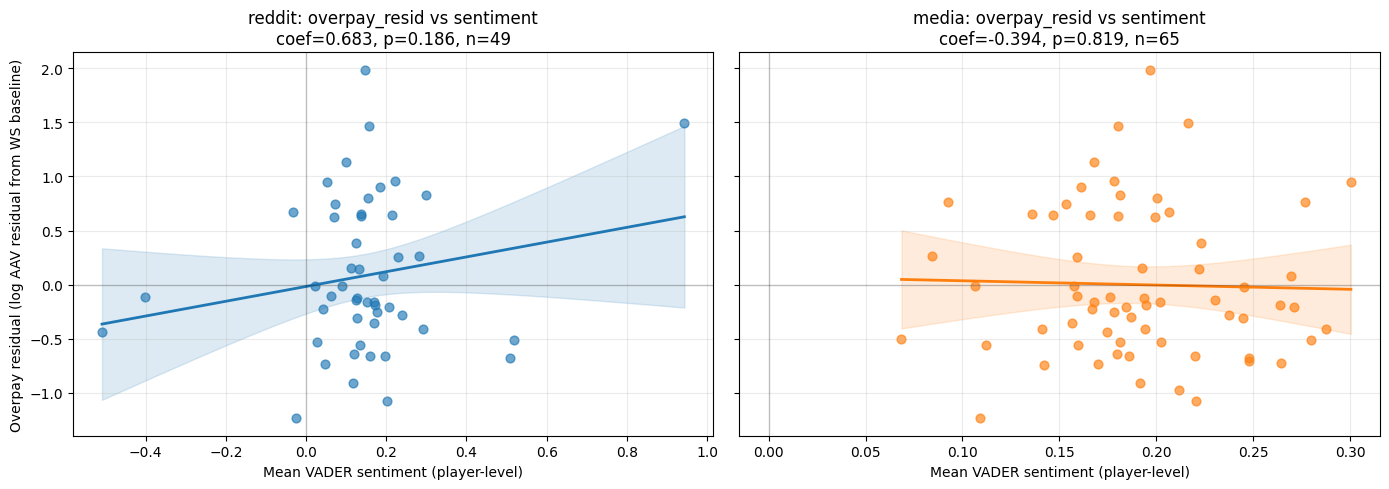

In [130]:
PRIMARY_SENTIMENT_MODEL = "vader"
SOURCES = ["reddit", "media"]
SOURCE_COLORS = {"reddit": "tab:blue", "media": "tab:orange"}


def prep_main_data(df_in: pd.DataFrame, *, source: str, sentiment_model: str) -> pd.DataFrame:
    sentiment_col = f"{source}_mean_{sentiment_model}"
    count_col = f"{source}_n_sentences"

    cols = ["player", "player_key_norm", "aav_mil", "WS", "log_aav_mil", "overpay_resid", sentiment_col]
    if count_col in df_in.columns:
        cols.append(count_col)

    d = df_in[cols].copy()
    d = d.rename(columns={sentiment_col: "sentiment_mean"})
    if count_col in d.columns:
        d = d.rename(columns={count_col: "n_sentences"})
    else:
        d["n_sentences"] = np.nan

    d = d.replace([np.inf, -np.inf], np.nan)
    d = d.dropna(subset=["log_aav_mil", "WS", "sentiment_mean"])
    d = d[d["aav_mil"] > 0]
    return d


def one_split_metrics(d: pd.DataFrame, formula: str, *, seed: int = 42, test_frac: float = 0.2):
    d = d.reset_index(drop=True)
    n = len(d)
    if n < 8:
        return {"rmse": np.nan, "r2": np.nan, "n_test": 0}

    rng_local = np.random.default_rng(seed)
    idx = rng_local.permutation(n)
    n_test = max(2, int(round(n * test_frac)))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]

    train = d.iloc[train_idx].copy()
    test = d.iloc[test_idx].copy()

    fit = smf.ols(formula, data=train).fit()
    pred = fit.predict(test)

    y = test["log_aav_mil"].to_numpy()
    yhat = pred.to_numpy()
    rmse = float(np.sqrt(np.mean((y - yhat) ** 2)))

    sse = float(np.sum((y - yhat) ** 2))
    sst = float(np.sum((y - float(np.mean(y))) ** 2))
    r2 = float(1.0 - sse / sst) if sst > 0 else np.nan

    return {"rmse": rmse, "r2": r2, "n_test": int(n_test)}


rows = []
fits = {}

for source in SOURCES:
    d = prep_main_data(df, source=source, sentiment_model=PRIMARY_SENTIMENT_MODEL)
    if len(d) < 8:
        print(f"Skipping main model for {source}: n={len(d)}")
        continue

    fit_base = smf.ols("log_aav_mil ~ WS", data=d).fit()
    fit_ext = smf.ols("log_aav_mil ~ WS + sentiment_mean", data=d).fit()

    cv_base = one_split_metrics(d, "log_aav_mil ~ WS", seed=42)
    cv_ext = one_split_metrics(d, "log_aav_mil ~ WS + sentiment_mean", seed=42)

    rows.append(
        {
            "source": source,
            "sentiment_model": PRIMARY_SENTIMENT_MODEL,
            "nobs": int(fit_ext.nobs),
            "baseline_r2": float(fit_base.rsquared),
            "extended_r2": float(fit_ext.rsquared),
            "delta_r2": float(fit_ext.rsquared - fit_base.rsquared),
            "baseline_adj_r2": float(fit_base.rsquared_adj),
            "extended_adj_r2": float(fit_ext.rsquared_adj),
            "delta_adj_r2": float(fit_ext.rsquared_adj - fit_base.rsquared_adj),
            "coef_sentiment": float(fit_ext.params.get("sentiment_mean", np.nan)),
            "p_sentiment": float(fit_ext.pvalues.get("sentiment_mean", np.nan)),
            "cv_n_test": int(cv_base["n_test"]),
            "cv_rmse_baseline": float(cv_base["rmse"]),
            "cv_rmse_extended": float(cv_ext["rmse"]),
            "cv_delta_rmse": float(cv_ext["rmse"] - cv_base["rmse"]),
            "cv_r2_baseline": float(cv_base["r2"]),
            "cv_r2_extended": float(cv_ext["r2"]),
            "cv_delta_r2": float(cv_ext["r2"] - cv_base["r2"]),
        }
    )

    fits[source] = {
        "d": d,
        "fit_base": fit_base,
        "fit_ext": fit_ext,
    }

main_results = pd.DataFrame(rows).sort_values("source").reset_index(drop=True)
display(main_results)

# Export a small results table for paper writing
out_path = OUTPUT_DIR / f"main_overpay_models_{PRIMARY_SENTIMENT_MODEL}.csv"
main_results.to_csv(out_path, index=False)
print("Wrote:", out_path)


# Figure: overpay residual vs sentiment, with fitted line + 95% CI
fig, axes = plt.subplots(1, len(SOURCES), figsize=(14, 5), sharey=True)
if len(SOURCES) == 1:
    axes = [axes]

for ax, source in zip(axes, SOURCES):
    if source not in fits:
        ax.set_axis_off()
        continue

    d = fits[source]["d"].dropna(subset=["overpay_resid", "sentiment_mean"]).copy()
    if len(d) < 3:
        ax.set_axis_off()
        continue

    fit = smf.ols("overpay_resid ~ sentiment_mean", data=d).fit()

    ax.scatter(d["sentiment_mean"], d["overpay_resid"], s=40, alpha=0.65, color=SOURCE_COLORS[source])

    xs = np.linspace(float(d["sentiment_mean"].min()), float(d["sentiment_mean"].max()), 200)
    pred = fit.get_prediction(pd.DataFrame({"sentiment_mean": xs})).summary_frame(alpha=0.05)

    ax.plot(xs, pred["mean"], color=SOURCE_COLORS[source], lw=2)
    ax.fill_between(xs, pred["mean_ci_lower"], pred["mean_ci_upper"], color=SOURCE_COLORS[source], alpha=0.15)

    coef = fit.params.get("sentiment_mean", np.nan)
    p = fit.pvalues.get("sentiment_mean", np.nan)
    ax.set_title(f"{source}: overpay_resid vs sentiment\ncoef={coef:.3g}, p={p:.3g}, n={len(d)}")
    ax.set_xlabel(f"Mean {PRIMARY_SENTIMENT_MODEL.upper()} sentiment (player-level)")
    ax.axhline(0, color="k", lw=1, alpha=0.2)
    ax.axvline(0, color="k", lw=1, alpha=0.2)

axes[0].set_ylabel("Overpay residual (log AAV residual from WS baseline)")
plt.tight_layout()


WS alone explains ~37% of variance in log(AAV) in this cohort, establishing a strong performance baseline for testing incremental sentiment effects.

Adding mean VADER sentiment provides no incremental fit for media (ΔR²≈0, ΔadjR²<0) and negligible CV change. Reddit shows a small improvement in fit and CV metrics, but the sentiment coefficient is not statistically robust (p=0.186), suggesting weak or unstable signal.

## Who is overpaid / underpaid (by residual)?

Define **overpay** as the residual from the baseline model `log(AAV) ~ WS`:

- `overpay_resid > 0` means the player is paid **above** what WS predicts (within this cohort)
- `overpay_resid < 0` means the player is paid **below** what WS predicts

Below we list the top and bottom players by this residual.


In [131]:
OVERPAY_TOP_K = 15

cols = [
    "player",
    "aav_mil",
    "WS",
    "overpay_resid",
    "aav_source",
    "years",
    "media_n_sentences",
    "media_mean_vader",
    "reddit_n_sentences",
    "reddit_mean_vader",
]
cols = [c for c in cols if c in df.columns]

base = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["overpay_resid"]).copy()

print(f"Players with overpay_resid available: {len(base)}")

over = base.sort_values("overpay_resid", ascending=False).head(OVERPAY_TOP_K).copy()
over["group"] = "overpaid"
under = base.sort_values("overpay_resid", ascending=True).head(OVERPAY_TOP_K).copy()
under["group"] = "underpaid"

over_under = pd.concat([over, under], ignore_index=True)
display(over_under[["group"] + cols].reset_index(drop=True))

# Save groups for the next section
overpaid_keys = over["player_key_norm"].astype(str).tolist()
underpaid_keys = under["player_key_norm"].astype(str).tolist()


Players with overpay_resid available: 65


,group,player,aav_mil,WS,overpay_resid,aav_source,years,media_n_sentences,media_mean_vader,reddit_n_sentences,reddit_mean_vader
0,overpaid,Deandre Ayton,43.654814,2.8,1.984457,fox_2025-26,NaN,626,0.196966,321.0,0.146893
1,overpaid,Jordan Clarkson,16.581988,0.4,1.494113,fox_2025-26,NaN,209,0.216425,1.0,0.943200
2,overpaid,Devin Booker,53.142264,6.4,1.464637,fox_2025-26,NaN,1221,0.180069,707.0,0.157601
3,overpaid,Myles Turner,27.217121,4.7,1.133848,spotrac,4.0,1142,0.167795,551.0,0.098815
4,overpaid,Steven Adams,14.130434,2.3,0.955985,fox_2025-26,NaN,388,0.177977,24.0,0.220812
5,overpaid,Fred VanVleet,25.000000,5.2,0.949366,spotrac,2.0,235,0.300329,4.0,0.053000
6,overpaid,Bobby Portis,14.521414,2.7,0.903670,spotrac,3.0,248,0.161382,9.0,0.184833
7,overpaid,Tre Mann,8.000000,0.1,0.824944,spotrac,3.0,240,0.181220,9.0,0.298433
8,overpaid,Paolo Banchero,15.334769,3.5,0.798951,fox_2025-26,NaN,523,0.200135,484.0,0.155275
9,overpaid,Dorian Finney-Smith,13.176250,2.9,0.766657,spotrac,4.0,22,0.092686,NaN,NaN


These examples illustrate how the residual-based definition identifies players paid above/below what the WS-only model predicts. Residuals may also reflect factors not modeled here (role, age, cap constraints), so this list is descriptive rather than causal.

## Sentiment around overpaid vs underpaid players (player-level)

To avoid sentence-level independence problems (thousands of sentences), we do this comparison at the **player level**:

- Overpaid group: top-K `overpay_resid`
- Underpaid group: bottom-K `overpay_resid`

We compare **mean player-level VADER sentiment** between the two groups and report a **bootstrap 95% CI** for the difference.


,source,sentiment_model,n_over_players_with_sent,n_under_players_with_sent,mean_overpaid,mean_underpaid,diff_under_minus_over,boot95_ci_low,boot95_ci_high
0,media,vader,15,15,0.186317,0.189559,0.003172,-0.031939,0.037288
1,reddit,vader,13,10,0.203837,0.148735,-0.054161,-0.218835,0.088248


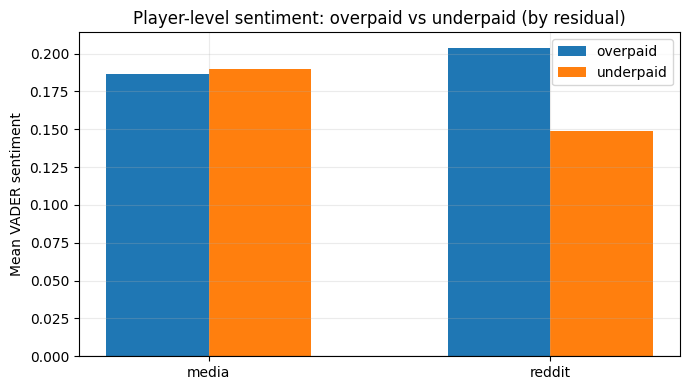

In [132]:
BOOT_N = 10000
GROUP_TOP_K = 15


def bootstrap_diff_mean(x: np.ndarray, y: np.ndarray, *, n_boot: int = 10000, seed: int = 42):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return {"diff": np.nan, "ci_low": np.nan, "ci_high": np.nan}

    rng_local = np.random.default_rng(seed)
    diffs = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        xb = rng_local.choice(x, size=len(x), replace=True)
        yb = rng_local.choice(y, size=len(y), replace=True)
        diffs[i] = float(np.mean(yb) - np.mean(xb))  # under - over

    ci_low, ci_high = np.quantile(diffs, [0.025, 0.975])
    return {"diff": float(np.mean(diffs)), "ci_low": float(ci_low), "ci_high": float(ci_high)}


rows = []
for source in ["reddit", "media"]:
    col = f"{source}_mean_vader"
    if col not in df.columns:
        continue

    over_vals = df[df["player_key_norm"].isin(overpaid_keys)][col].dropna().to_numpy()
    under_vals = df[df["player_key_norm"].isin(underpaid_keys)][col].dropna().to_numpy()

    stats_out = bootstrap_diff_mean(over_vals, under_vals, n_boot=BOOT_N, seed=42)

    rows.append(
        {
            "source": source,
            "sentiment_model": "vader",
            "n_over_players_with_sent": int(len(over_vals)),
            "n_under_players_with_sent": int(len(under_vals)),
            "mean_overpaid": float(np.mean(over_vals)) if len(over_vals) else np.nan,
            "mean_underpaid": float(np.mean(under_vals)) if len(under_vals) else np.nan,
            "diff_under_minus_over": stats_out["diff"],
            "boot95_ci_low": stats_out["ci_low"],
            "boot95_ci_high": stats_out["ci_high"],
        }
    )

group_player_level = pd.DataFrame(rows).sort_values("source").reset_index(drop=True)
display(group_player_level)

# Optional quick plot (means)
if not group_player_level.empty:
    fig, ax = plt.subplots(figsize=(7, 4))
    x = np.arange(len(group_player_level))
    ax.bar(x - 0.15, group_player_level["mean_overpaid"], width=0.3, label="overpaid")
    ax.bar(x + 0.15, group_player_level["mean_underpaid"], width=0.3, label="underpaid")
    ax.set_xticks(x)
    ax.set_xticklabels(group_player_level["source"].tolist())
    ax.set_ylabel("Mean VADER sentiment")
    ax.set_title("Player-level sentiment: overpaid vs underpaid (by residual)")
    ax.axhline(0, color="k", lw=1, alpha=0.2)
    ax.legend()
    plt.tight_layout()


Mean sentiment differences between overpaid and underpaid groups are small with wide bootstrap intervals, consistent with the regression finding that sentiment does not reliably separate the groups

## Robustness note: repeat the main test with DeBERTa

To avoid a "we tried everything", the main analysis uses **VADER**.

Here we repeat the same baseline vs extended comparison using **DeBERTa mean sentiment** as a robustness check.


In [133]:
rows = []
for source in ["reddit", "media"]:
    d = prep_main_data(df, source=source, sentiment_model="deberta")
    if len(d) < 8:
        continue

    fit_base = smf.ols("log_aav_mil ~ WS", data=d).fit()
    fit_ext = smf.ols("log_aav_mil ~ WS + sentiment_mean", data=d).fit()

    rows.append(
        {
            "source": source,
            "sentiment_model": "deberta",
            "nobs": int(fit_ext.nobs),
            "baseline_adj_r2": float(fit_base.rsquared_adj),
            "extended_adj_r2": float(fit_ext.rsquared_adj),
            "delta_adj_r2": float(fit_ext.rsquared_adj - fit_base.rsquared_adj),
            "coef_sentiment": float(fit_ext.params.get("sentiment_mean", np.nan)),
            "p_sentiment": float(fit_ext.pvalues.get("sentiment_mean", np.nan)),
        }
    )

deberta_robust = pd.DataFrame(rows).sort_values("source").reset_index(drop=True)
display(deberta_robust)


,source,sentiment_model,nobs,baseline_adj_r2,extended_adj_r2,delta_adj_r2,coef_sentiment,p_sentiment
0,media,deberta,65,0.358337,0.348284,-0.010053,-0.167550,0.867089
1,reddit,deberta,49,0.326875,0.324283,-0.002592,0.354827,0.369985


Using DeBERTa mean sentiment does not reproduce the modest Reddit lift seen with VADER, reinforcing that any sentiment–salary association is sensitive to sentiment model choice and likely small.

## Robustness check (media quality): exclude `pronoun_backfill`

Media sentence attribution uses `pronoun_backfill` heavily (see EDA), and those sentences are more neutral on average.

As a single robustness check for measurement noise, we recompute **media player-level VADER sentiment** using only explicitly attributed sentences (exclude `pronoun_backfill`) and rerun the main baseline vs extended comparison.


In [134]:
if "tie_breaker" not in media_sent.columns:
    print("media_sent has no tie_breaker column; cannot run pronoun_backfill robustness.")
else:
    media_explicit_sent = media_sent[media_sent["tie_breaker"] != "pronoun_backfill"].copy()
    media_explicit_player = aggregate_sentiment(media_explicit_sent, "media_explicit_")

    df_explicit = df.merge(media_explicit_player, on="player_key_norm", how="left")

    # Compare main (all media sentences) vs explicit-only media sentiment
    def fit_pair(d: pd.DataFrame):
        fit_base = smf.ols("log_aav_mil ~ WS", data=d).fit()
        fit_ext = smf.ols("log_aav_mil ~ WS + sentiment_mean", data=d).fit()
        return fit_base, fit_ext

    # Main media (all)
    d_all = prep_main_data(df, source="media", sentiment_model="vader")

    # Explicit-only media
    d_exp = df_explicit[
        [
            "player",
            "player_key_norm",
            "aav_mil",
            "WS",
            "log_aav_mil",
            "overpay_resid",
            "media_explicit_mean_vader",
        ]
    ].copy()
    d_exp = d_exp.rename(columns={"media_explicit_mean_vader": "sentiment_mean"})
    d_exp = d_exp.replace([np.inf, -np.inf], np.nan)
    d_exp = d_exp.dropna(subset=["log_aav_mil", "WS", "sentiment_mean"])
    d_exp = d_exp[d_exp["aav_mil"] > 0]

    rows = []
    if len(d_all) >= 8:
        b0, e0 = fit_pair(d_all)
        rows.append(
            {
                "sentiment_model": "vader",
                "variant": "media_all_sentences",
                "nobs": int(e0.nobs),
                "baseline_adj_r2": float(b0.rsquared_adj),
                "extended_adj_r2": float(e0.rsquared_adj),
                "delta_adj_r2": float(e0.rsquared_adj - b0.rsquared_adj),
                "coef_sentiment": float(e0.params.get("sentiment_mean", np.nan)),
                "p_sentiment": float(e0.pvalues.get("sentiment_mean", np.nan)),
            }
        )

    if len(d_exp) >= 8:
        b1, e1 = fit_pair(d_exp)
        rows.append(
            {
                "sentiment_model": "vader",
                "variant": "media_explicit_only",
                "nobs": int(e1.nobs),
                "baseline_adj_r2": float(b1.rsquared_adj),
                "extended_adj_r2": float(e1.rsquared_adj),
                "delta_adj_r2": float(e1.rsquared_adj - b1.rsquared_adj),
                "coef_sentiment": float(e1.params.get("sentiment_mean", np.nan)),
                "p_sentiment": float(e1.pvalues.get("sentiment_mean", np.nan)),
            }
        )

    media_pronoun_robust = pd.DataFrame(rows)
    display(media_pronoun_robust)


,sentiment_model,variant,nobs,baseline_adj_r2,extended_adj_r2,delta_adj_r2,coef_sentiment,p_sentiment
0,vader,media_all_sentences,65,0.358337,0.348533,-0.009804,-0.394708,0.820469
1,vader,media_explicit_only,64,0.363021,0.367716,0.004695,-1.552840,0.231527


Restricting media to explicitly attributed sentences does not materially change conclusions: sentiment remains a weak predictor of salary beyond WS